# Task5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/movies.csv')
ratings_small = pd.read_csv('../data/ratings_small.csv')

In [3]:
df.dropna(inplace=True)
df = df.drop_duplicates().reset_index(drop=True)

In [4]:
ratings_matrix = ratings_small.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [5]:
ratings_matrix.index

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       662, 663, 664, 665, 666, 667, 668, 669, 670, 671],
      dtype='int64', name='userId', length=671)

In [ ]:
# Find CB
user_id =1


from sklearn.metrics.pairwise import cosine_similarity
cb_features = ['genres','keywords','cast','crew']
df_cb = df[cb_features].fillna('').apply(lambda x: x.str.lower())  

# Convert to simple bag-of-words vectors
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
cb_matrix = vec.fit_transform(df_cb.apply(lambda x: ' '.join(x), axis=1))

# Compute similarity between all items
cb_sim = cosine_similarity(cb_matrix)

# For user, average CB scores of items they rated
user_ratings = ratings_matrix.loc[user_id]
user_rated_items = user_ratings.to_numpy().nonzero()[0]
sCB = cb_sim[user_rated_items,:].mean(axis=0) if len(user_rated_items) > 0 else np.zeros(cb_sim.shape[0])

In [ ]:
# Find CF
user_ratings = ratings_matrix[user_id].copy()
user_mean = user_ratings[user_ratings > 0].mean() if np.any(user_ratings > 0) else 0
sCF = user_ratings.copy()
sCF[sCF == 0] = user_mean

In [ ]:
# Map movie IDs in df to their row indices
movie_id_to_idx = {mid: i for i, mid in enumerate(df['id'])}
sCF_full = np.zeros(len(df)) 

for mid, score in sCF.items(): 
    if mid in movie_id_to_idx:
        idx = movie_id_to_idx[mid]
        sCF_full[idx] = score

In [ ]:
# Normalize scores
scaler = MinMaxScaler()
sCF_norm = scaler.fit_transform(sCF_full.reshape(-1,1)).flatten()
sCB_norm = scaler.fit_transform(sCB.reshape(-1,1)).flatten()

In [10]:
alpha = 0.7  # tune on validation
s_hyb = alpha * sCF_norm + (1 - alpha) * sCB_norm

In [11]:
# List of movie IDs in order of df
item_ids = df['id'].tolist()
item_ids

[862,
 862,
 862,
 862,
 862,
 862,
 862,
 862,
 862,
 8844,
 8844,
 8844,
 8844,
 8844,
 8844,
 8844,
 8844,
 15602,
 15602,
 15602,
 15602,
 15602,
 15602,
 15602,
 15602,
 15602,
 15602,
 31357,
 31357,
 31357,
 31357,
 31357,
 11862,
 11862,
 11862,
 11862,
 11862,
 11862,
 11862,
 11862,
 949,
 949,
 949,
 949,
 949,
 949,
 949,
 949,
 11860,
 11860,
 11860,
 11860,
 11860,
 11860,
 11860,
 9091,
 9091,
 9091,
 9091,
 9091,
 710,
 710,
 710,
 710,
 710,
 710,
 710,
 710,
 710,
 9087,
 9087,
 9087,
 9087,
 9087,
 9087,
 9087,
 9087,
 9087,
 12110,
 12110,
 12110,
 12110,
 12110,
 12110,
 21032,
 21032,
 21032,
 21032,
 21032,
 10858,
 10858,
 10858,
 10858,
 10858,
 10858,
 1408,
 1408,
 1408,
 1408,
 1408,
 524,
 524,
 524,
 524,
 524,
 524,
 524,
 524,
 4584,
 4584,
 4584,
 4584,
 4584,
 4584,
 4584,
 4584,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 9273,
 9273,
 9273,
 9273,
 9273,
 9273,
 9273,
 9273,
 9273,
 9273,
 11517,
 11517,
 11517,
 11517,
 11517,
 11517,
 11517,
 8012,
 8012,
 80

In [ ]:
# Top-10 indices
top_indices = s_hyb.argsort()[::-1][:10]

recommended_titles = [df.loc[i, 'title'] for i in top_indices]

print("Top-10 hybrid recommendations:")
print(recommended_titles)

Top-10 hybrid recommendations:
['Monsoon Wedding', 'Italian for Beginners', 'To Die For', 'Volver', 'Harold and Maude', 'Forrest Gump', 'Jackie Brown', 'Garden State', 'A Grand Day Out', 'Bull Durham']


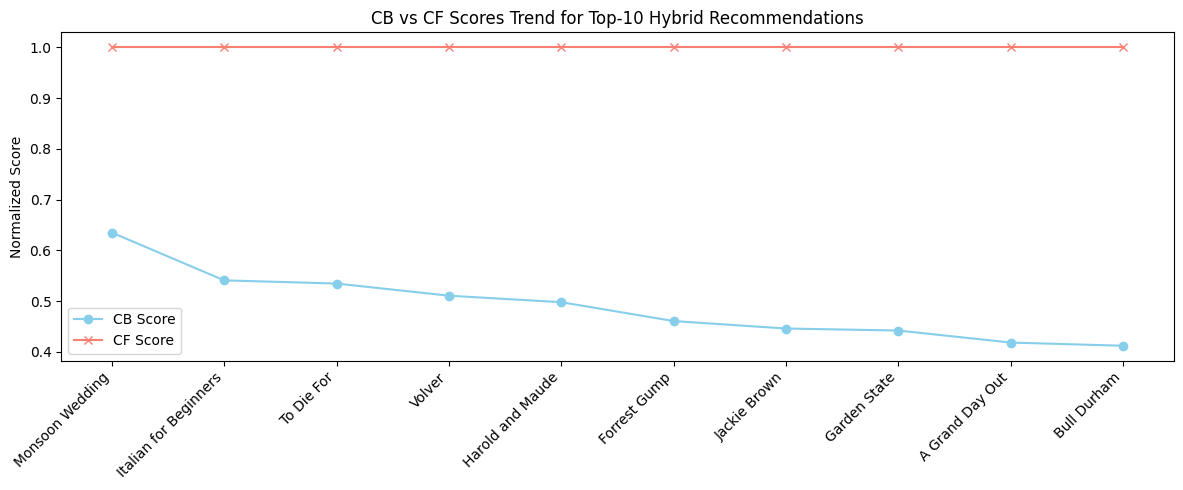

In [ ]:
# CB VS CF PLOT
top_n = 10
indices = s_hyb.argsort()[::-1][:top_n]
titles = [df.loc[i, 'title'] for i in indices]
cb_scores = sCB_norm[indices]
cf_scores = sCF_norm[indices]

x = np.arange(len(titles))
width = 0.35
# Scatter plot of CB vs CF scores
plt.figure(figsize=(12,5))
plt.plot(cb_scores, marker='o', label='CB Score', color='skyblue')
plt.plot(cf_scores, marker='x', label='CF Score', color='salmon')
plt.xticks(range(top_n), titles, rotation=45, ha='right')
plt.ylabel("Normalized Score")
plt.title(f"CB vs CF Scores Trend for Top-{top_n} Hybrid Recommendations")
plt.legend()
plt.tight_layout()
plt.show()
plt.show()


In [14]:
# SAVE 
import pickle
model = {
    "cb_sim": cb_sim,
    "vectorizer": vec,
    "movie_id_to_idx": movie_id_to_idx
}

with open("models/hybrid.pkl", "wb") as f:
    pickle.dump(model, f)


with open("models/hybrid_df.pkl", "wb") as f:
    pickle.dump(df, f)